In [1]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 


from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn import metrics

plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set_context("paper", font_scale=1.2)

In [2]:
# ar data with flares
data_ar = pd.read_csv("AR_flare_ml_23_24.csv")

# evolution data
data_ar_evol = pd.read_csv("AR_flare_ml_23_24_evol.csv")
row_has_NaN = data_ar_evol.isnull().any(axis=1)
data_ar_evol = data_ar_evol[~row_has_NaN]
data_ar_evol["evolution_mcint"] = data_ar_evol["pre_mcint"] + data_ar_evol["McIntosh"]

In [3]:
def get_flare_rates(data):
    """
    Determine flare rates for each McIntosh classification given an input 
    dataframe of AR-flare data.
    """

    flare_number_per_group = data.groupby(["McIntosh"])[["C+", "M+", "X+"]].sum().reset_index()
    total_per_group = data.groupby(["McIntosh"])["C+"].count().reset_index().rename(columns={"C+":"N"})
    flare_number_per_group["N"] = total_per_group["N"]

    flare_rates_per_group = flare_number_per_group.set_index("McIntosh")[["C+", "M+", "X+"]].div(flare_number_per_group["N"].values, axis=0)

    flare_number_per_group["C_rate"] = flare_rates_per_group["C+"].values
    flare_number_per_group["M_rate"] = flare_rates_per_group["M+"].values
    flare_number_per_group["X_rate"] = flare_rates_per_group["X+"].values

    return flare_number_per_group

flare_rates = get_flare_rates(data_ar)

In [4]:
i = 2200
mcint = data_ar.iloc[i]["McIntosh"]
flare_rate_mcint = flare_rates[flare_rates["McIntosh"].isin([mcint])]

c_prob = 1-np.exp(-flare_rate_mcint["C_rate"].values[0])
m_prob = 1-np.exp(-flare_rate_mcint["M_rate"].values[0])
x_prob = 1-np.exp(-flare_rate_mcint["X_rate"].values[0])

print("Probability of C-class flare: {:f}".format(c_prob))
print("Probability of M-class flare: {:f}".format(m_prob))
print("Probability of X-class flare: {:f}".format(x_prob))


Probability of C-class flare: 0.468916
Probability of M-class flare: 0.084294
Probability of X-class flare: 0.001491


In [5]:
def get_predicted_flare_rates(flare_rates, mcint):
    flare_rate_mcint = flare_rates[flare_rates["McIntosh"].isin([mcint])]
    if len(flare_rate_mcint)==0:
        return 0, 0, 0
    c_prob = 1-np.exp(-flare_rate_mcint["C_rate"].values[0])
    m_prob = 1-np.exp(-flare_rate_mcint["M_rate"].values[0])
    x_prob = 1-np.exp(-flare_rate_mcint["X_rate"].values[0])
    return c_prob, m_prob, x_prob


In [6]:
def get_tss(true_vals, pred_vals, thresh):

    pred_y_thresh = [1 if x>thresh else 0 for x in pred_vals]
    tn, fp, fn, tp = confusion_matrix(true_vals, pred_y_thresh).ravel()
    TSS = (tp / (tp + fn)) - (fp / (fp + tn))
    return TSS

## Define the training and testing data

In [7]:
train_ar = data_ar[~(data_ar["AR issue_date"]>="2016-01-01")&(data_ar["AR issue_date"]<="2017-12-31")]
test_ar = data_ar[(data_ar["AR issue_date"]>="2016-01-01")&(data_ar["AR issue_date"]<="2017-12-31")]


flare_rates_train = get_flare_rates(train_ar)
X_test = test_ar["McIntosh"].values

In [8]:
np.sum(train_ar["C+"]), np.sum(test_ar["C+"])

(14465.0, 494.0)

In [9]:
flare_rates_train

,McIntosh,C+,M+,X+,N,C_rate,M_rate,X_rate
0,AXX,169.0,9.0,0.0,3114,0.054271,0.002890,0.000000
1,BXI,6.0,0.0,0.0,16,0.375000,0.000000,0.000000
2,BXO,382.0,17.0,0.0,3732,0.102358,0.004555,0.000000
3,CAI,92.0,5.0,0.0,103,0.893204,0.048544,0.000000
4,CAO,543.0,48.0,0.0,1909,0.284442,0.025144,0.000000
...,...,...,...,...,...,...,...,...
58,HKX,43.0,4.0,3.0,122,0.352459,0.032787,0.024590
59,HRX,73.0,2.0,0.0,676,0.107988,0.002959,0.000000
60,HSO,0.0,0.0,0.0,1,0.000000,0.000000,0.000000
61,HSX,408.0,38.0,1.0,4337,0.094074,0.008762,0.000231


In [10]:
y_test_c = test_ar["C+"].map(lambda x: 1 if x>0 else 0).values
y_test_m = test_ar["M+"].map(lambda x: 1 if x>0 else 0).values
y_test_x = test_ar["X+"].map(lambda x: 1 if x>0 else 0).values

In [11]:
pred_y_c = [get_predicted_flare_rates(flare_rates_train, x)[0] for x in X_test]
pred_y_m = [get_predicted_flare_rates(flare_rates_train, x)[1] for x in X_test]
pred_y_x = [get_predicted_flare_rates(flare_rates_train, x)[2] for x in X_test]

In [12]:
thresholds = np.linspace(0.01, 1, 100)
tss_c, tss_m, tss_x = [], [], []
for t in thresholds:
    tss_c.append(get_tss(y_test_c, pred_y_c, t))
    tss_m.append(get_tss(y_test_m, pred_y_m, t))
    tss_x.append(get_tss(y_test_x, pred_y_x, t))

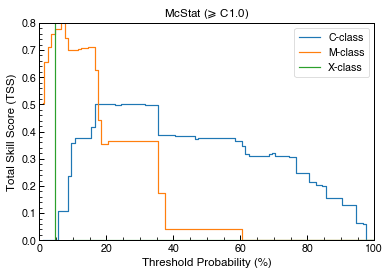

In [13]:
fig, ax = plt.subplots()
ax.plot(thresholds*100, tss_c, drawstyle="steps-mid", label="C-class")
ax.plot(thresholds*100, tss_m, drawstyle="steps-mid", label="M-class")
ax.plot(thresholds*100, tss_x, drawstyle="steps-mid", label="X-class")

ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.8)
ax.set_xlabel("Threshold Probability (%)")
ax.set_ylabel("Total Skill Score (TSS)")

ax.set_title("McStat ($\geqslant$ C1.0)")
plt.savefig("./overview_plots/threshold_mcstat.png", dpi=300, facecolor="w", bbox_inches="tight")

In [14]:
fpr, tpr, _ = metrics.roc_curve(y_test_c, pred_y_c)
auc_mcstat = metrics.auc(fpr, tpr)
climatology_mcstat = np.mean(y_test_c)

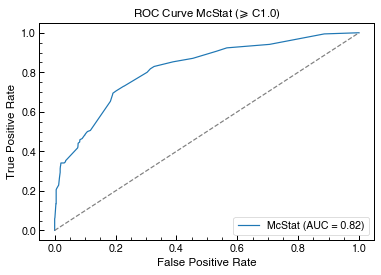

In [15]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label="McStat (AUC = {:.2f})".format(auc_mcstat))
ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.set_title("ROC Curve McStat ($\geqslant$ C1.0)")
plt.savefig("./overview_plots/roc_mcstat.png", dpi=300, facecolor="w", bbox_inches="tight")

In [16]:
from metric_utils import *

In [17]:
calculate_bss(y_test_c, pred_y_c)

0.15418619072867834

In [18]:
calculate_tss(y_test_c, [1 if x > 0.4 else 0 for x in pred_y_c])

0.3872500724427702

In [19]:
calculate_tss_threshold(y_test_c, pred_y_c, thresh=0.4)

0.3872500724427702

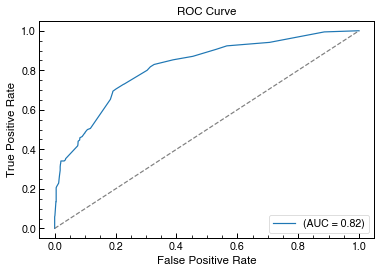

In [20]:
plot_roc_curve(y_test_c, pred_y_c)

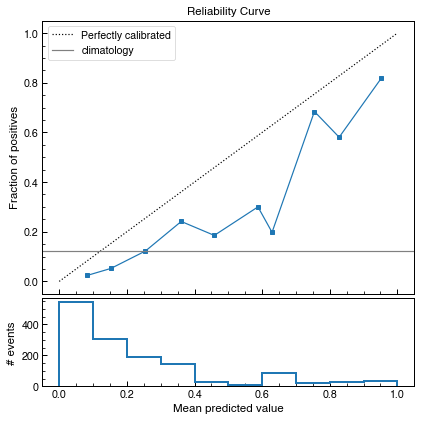

In [21]:
plot_reliability_curve(y_test_c, pred_y_c)

In [ ]:
fraction_of_positives_c, mean_predicted_value_c = calibration_curve(y_test_c, pred_y_c, n_bins=10)
fraction_of_positives_m, mean_predicted_value_m = calibration_curve(y_test_m, pred_y_m, n_bins=10)
fraction_of_positives_x, mean_predicted_value_x = calibration_curve(y_test_x, pred_y_x, n_bins=20)


fig = plt.figure(figsize=(6,6))
gs1 = fig.add_gridspec(nrows=4, ncols=1)

ax1 = fig.add_subplot(gs1[0:3, 0])
ax2 = fig.add_subplot(gs1[3, 0], sharex=ax1)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value_c, fraction_of_positives_c, "s-")
ax1.set_ylabel("Fraction of positives")
ax1.tick_params(which="both", labelbottom=False)
ax1.axhline(climatology_mcstat, color="grey", label="climatology")
ax1.legend()
ax1.set_title("McStat ($\geqslant$ C1.0) ")

ax2.hist(pred_y_c, range=(0, 1), bins=10, 
         histtype="step", lw=2)
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("# events")

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./overview_plots/reliability_mcstat.png", dpi=300, facecolor="w", bbox_inches="tight")

In [ ]:

def plot_reliability_curve(true_vals, pred_vals, n_bins=10):


    fraction_of_positives, mean_predicted_value = calibration_curve(true_vals, pred_vals, n_bins=n_bins)
    climatology = np.mean(true_vals)

    fig = plt.figure(figsize=(6,6))
    gs1 = fig.add_gridspec(nrows=4, ncols=1)
    ax1 = fig.add_subplot(gs1[0:3, 0])
    ax2 = fig.add_subplot(gs1[3, 0], sharex=ax1)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-")
    
    ax1.set_ylabel("Fraction of positives")
    ax1.tick_params(which="both", labelbottom=False)
    ax1.axhline(climatology, color="grey", label="climatology")
    ax1.legend()
    ax1.set_title("Reliability Curve")

    ax2.hist(pred_y_c, range=(0, 1), bins=10, 
             histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("# events")

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.05)


In [ ]:
plot_reliability_curve(y_test_c, pred_y_c)

In [ ]:
bss_mcstat = calculate_bss(y_test_c, pred_y_c)
tss_mcstat = np.max(tss_c)

In [ ]:
print(bss_mcstat, tss_mcstat)

## McEvol

In [ ]:
def get_flare_rates_evol(data):
    """
    Determine flare rates for each McIntosh classification given an input 
    dataframe of AR-flare data.
    """

    flare_number_per_group = data.groupby(["evolution_mcint"])[["C+", "M+", "X+"]].sum().reset_index()
    total_per_group = data.groupby(["evolution_mcint"])["C+"].count().reset_index().rename(columns={"C+":"N"})
    flare_number_per_group["N"] = total_per_group["N"]

    flare_rates_per_group = flare_number_per_group.set_index("evolution_mcint")[["C+", "M+", "X+"]].div(flare_number_per_group["N"].values, axis=0)

    flare_number_per_group["C_rate"] = flare_rates_per_group["C+"].values
    flare_number_per_group["M_rate"] = flare_rates_per_group["M+"].values
    flare_number_per_group["X_rate"] = flare_rates_per_group["X+"].values

    return flare_number_per_group

In [ ]:
flare_rates_evol = get_flare_rates_evol(data_ar_evol)

In [ ]:
def get_predicted_flare_rates_evol(flare_rates, mcint):
    flare_rate_mcint = flare_rates[flare_rates["evolution_mcint"].isin([mcint])]
    if len(flare_rate_mcint)==0:
        return 0, 0, 0
    c_prob = 1-np.exp(-flare_rate_mcint["C_rate"].values[0])
    m_prob = 1-np.exp(-flare_rate_mcint["M_rate"].values[0])
    x_prob = 1-np.exp(-flare_rate_mcint["X_rate"].values[0])
    return c_prob, m_prob, x_prob

In [ ]:
train_ar_evol = data_ar_evol[data_ar_evol["AR issue_date"]<="2009-01-01"]
test_ar_evol = data_ar_evol[data_ar_evol["AR issue_date"]>="2008-12-31"]

flare_rates_train_evol = get_flare_rates_evol(train_ar_evol)

X_test_evol = test_ar_evol["evolution_mcint"].values

In [ ]:
y_test_c_evol = test_ar_evol["C+"].map(lambda x: 1 if x>0 else 0).values
y_test_m_evol = test_ar_evol["M+"].map(lambda x: 1 if x>0 else 0).values
y_test_x_evol = test_ar_evol["X+"].map(lambda x: 1 if x>0 else 0).values

In [ ]:
pred_y_c_evol = [get_predicted_flare_rates_evol(flare_rates_train_evol, x)[0] for x in X_test_evol]
pred_y_m_evol = [get_predicted_flare_rates_evol(flare_rates_train_evol, x)[1] for x in X_test_evol]
pred_y_x_evol = [get_predicted_flare_rates_evol(flare_rates_train_evol, x)[2] for x in X_test_evol]

In [ ]:
thresholds = np.linspace(0.01, 1, 100)
tss_c_evol, tss_m_evol, tss_x_evol = [], [], []
for t in thresholds:
    tss_c_evol.append(get_tss(y_test_c_evol, pred_y_c_evol, t))
    tss_m_evol.append(get_tss(y_test_m_evol, pred_y_m_evol, t))
    tss_x_evol.append(get_tss(y_test_x_evol, pred_y_x_evol, t))

In [ ]:
fig, ax = plt.subplots()
ax.plot(thresholds*100, tss_c_evol, drawstyle="steps-mid", label="C-class")
ax.plot(thresholds*100, tss_m_evol, drawstyle="steps-mid", label="M-class")
ax.plot(thresholds*100, tss_x_evol, drawstyle="steps-mid", label="X-class")


# ax.plot(thresholds*100, tss_c, drawstyle="steps-mid",ls="dashed", label="C-class")
# ax.plot(thresholds*100, tss_m, drawstyle="steps-mid",ls="dashed", label="M-class")
# ax.plot(thresholds*100, tss_x, drawstyle="steps-mid",ls="dashed", label="X-class")

ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.8)
ax.set_xlabel("Threshold Probability (%)")
ax.set_ylabel("Total Skill Score (TSS)")

ax.set_title("McEvol ($\geqslant$ C1.0)")
plt.savefig("./overview_plots/threshold_mcevol.png", dpi=300, facecolor="w", bbox_inches="tight")

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_test_c_evol, pred_y_c_evol)
auc_mcevol = metrics.auc(fpr, tpr)
climatology_mcevol = np.mean(y_test_c)

In [ ]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label="McEvol (AUC = {:.2f})".format(auc_mcevol))
ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
ax.set_title("ROC Curve McEvol ($\geqslant$ C1.0)")
plt.savefig("./overview_plots/roc_mcevol.png", dpi=300, facecolor="w", bbox_inches="tight")

In [ ]:
fraction_of_positives_c_evol, mean_predicted_value_c_evol = calibration_curve(y_test_c_evol, pred_y_c_evol, n_bins=10)
fraction_of_positives_m_evol, mean_predicted_value_m_evol = calibration_curve(y_test_m_evol, pred_y_m_evol, n_bins=10)
fraction_of_positives_x_evol, mean_predicted_value_x_evol = calibration_curve(y_test_x_evol, pred_y_x_evol, n_bins=20)

fig = plt.figure(figsize=(6,6))
gs1 = fig.add_gridspec(nrows=4, ncols=1)

ax1 = fig.add_subplot(gs1[0:3, 0])
ax2 = fig.add_subplot(gs1[3, 0], sharex=ax1)

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value_c_evol, fraction_of_positives_c_evol, "s-")
ax1.set_ylabel("Fraction of positives")
ax1.tick_params(which="both", labelbottom=False)
ax1.axhline(climatology_mcevol, color="grey", label="climatology")
ax1.legend()
ax1.set_title("McEvol ($\geqslant$ C1.0) ")

ax2.hist(pred_y_c_evol, range=(0, 1), bins=10, 
         histtype="step", lw=2)
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("# events")

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./overview_plots/reliability_mcevol.png", dpi=300, facecolor="w", bbox_inches="tight")

In [ ]:
bss_mcevol = calculate_bss(y_test_c_evol, pred_y_c_evol)
tss_mcevol = np.max(tss_c_evol)

In [ ]:
print(bss_mcevol, tss_mcevol)

In [ ]:
from metric_utils import *